# Perturbative solver demo

This demo walks through the construction and usage of `PerturbativeSolver` objects for simulating a 2 transmon gate, comparing to traditional solvers using both dense and sparse arrays.

In [1]:
from time import time

import numpy as np

import jax.numpy as jnp
from jax.scipy.linalg import expm as jexpm
from jax.scipy.special import erf
from jax import jit, value_and_grad


from qiskit.quantum_info import Operator

from qiskit_dynamics import Solver, Signal
from qiskit_dynamics.perturbation import PerturbativeSolver

Configure to use JAX.

In [2]:
from qiskit_dynamics.array import Array

# configure jax to use 64 bit mode
import jax
jax.config.update("jax_enable_x64", True)

# tell JAX we are using CPU
jax.config.update('jax_platform_name', 'cpu')

# set default backend
Array.set_default_backend('jax')

# 1. Define envelope functions

We define a Gaussian square and bipolar Gaussian square pulse shape.

In [3]:
def gaussian_square(t, amp, sigma, risefall, T):
    """Gaussian square pulse."""
    
    t = Array(t).data
    C = jnp.exp(-(2*risefall*sigma)**2/(8*sigma**2))
    den = (jnp.sqrt(jnp.pi*2*sigma**2)*erf(2*risefall*sigma/(jnp.sqrt(8)*sigma))-2*risefall*sigma*C)
    return amp * jnp.piecewise(t,
                         condlist=[t < (risefall * sigma), (T - t) < (risefall * sigma)],
                         funclist=[lambda s: (jnp.exp(-(s-sigma*risefall)**2/(2*sigma**2))-C)/den,
                                   lambda s: (jnp.exp(-(T-s-sigma*risefall)**2/(2*sigma**2))-C)/den,
                                   lambda s: (1-C)/den]
                        )

def bipolar_gaussian_square(t, amp, sigma, risefall, T):
    t = Array(t).data
    unipolar = lambda s: gaussian_square(s, amp, sigma, risefall, T/2)
    return jnp.piecewise(t,
                         condlist=[t < (T/2)],
                         funclist=[unipolar, lambda s: -unipolar(s - T/2)])

Plot an example.

In [4]:
T = 300.
risefall = 2.
sigma = 15.
amp=4.

test = jnp.vectorize(lambda t: bipolar_gaussian_square(t, amp, sigma, risefall, T))

sig = Signal(test)

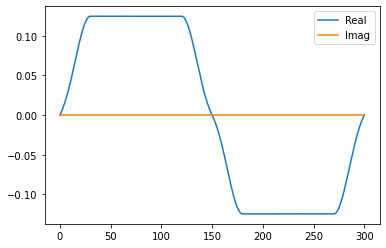

In [5]:
sig.draw(0, T, 1000, function='envelope')

# 2. Construct model operators

We construct a two transmon model:

$$H(t) = 2 \pi \nu a_0 a_0^\dagger + 2 \pi r (a_0 + a_0^\dagger) \\
   + 2 \pi \nu a_1 a_1^\dagger + 2 \pi r (a_1 + a_1^\dagger)\\
   + 2 \pi J (a_0a_1^\dagger + a_0^\dagger a_1)$$

In [268]:
w_c = 2 * np.pi * 5.105
w_t = 2 * np.pi * 5.033
alpha_c = 2 * np.pi * (-0.33534)
alpha_t = 2 * np.pi * (-0.33834)
J = 2 * np.pi * 0.002

dim = 4

a = np.diag(np.sqrt(np.arange(1, dim)), 1)
adag = a.transpose()
N = np.diag(np.arange(dim))
ident = np.eye(dim)
ident2 = np.eye(dim**2)

# operators on the control qubit (first tensor factor)
a0 = np.kron(a, ident)
adag0 = np.kron(adag, ident)
N0 = np.kron(N, ident)

# operators on the target qubit (first tensor factor)
a1 = np.kron(ident, a)
adag1 = np.kron(ident, adag)
N1 = np.kron(ident, N)

In [269]:
H0 = (w_c * N0 + 0.5 * alpha_c * N0 @ (N0 - ident2)
      + w_t * N1 + 0.5 * alpha_t * N1 @ (N1 - ident2)
      + J * (a0 @ adag1 + adag0 @ a1))
Hdc = 2 * np.pi * (a0 + adag0)
Hdt = 2 * np.pi * (a1 + adag1)

## 2.1 Get the dressed computational states qubit frequencies

In [270]:
def basis_vec(ind, dimension):
    vec = np.zeros(dimension, dtype=complex)
    vec[ind] = 1.
    return vec

def two_q_basis_vec(inda, indb, dimension):
    vec_a = basis_vec(inda, dimension)
    vec_b = basis_vec(indb, dimension)
    return np.kron(vec_a, vec_b)

def get_dressed_state_index(inda, indb, dimension, evectors):
    b_vec = two_q_basis_vec(inda, indb, dimension)
    overlaps = np.abs(evectors @ b_vec)
    return overlaps.argmax()

def get_dressed_state_and_energy(inda, indb, dimension, evecs):
    ind = get_dressed_state_index(inda, indb, dimension, evecs)
    return evals[ind], evecs[ind]

Diagonalize and get dressed energies/states for computational states.

In [271]:
evals, B = jnp.linalg.eigh(H0)
Badj = B.conj().transpose()

E00, dressed00 = get_dressed_state_and_energy(0, 0, dim, B.transpose())
E01, dressed01 = get_dressed_state_and_energy(0, 1, dim, B.transpose())
E10, dressed10 = get_dressed_state_and_energy(1, 0, dim, B.transpose())
E11, dressed11 = get_dressed_state_and_energy(1, 1, dim, B.transpose())

# "target dressed frequency"
v_t = E01 / (2 * np.pi)

In [272]:
H0_B = Badj @ H0 @ B
Hdc_B = Badj @ Hdc @ B
Hdt_B = Badj @ Hdt @ B

Define fidelity with respect to the $Z \otimes X$ operator for the computational states.

In [273]:
idx00 = 0
idx01 = get_dressed_state_index(0, 1, dim, B.transpose())
idx10 = get_dressed_state_index(1, 0, dim, B.transpose())
idx11 = get_dressed_state_index(1, 1, dim, B.transpose())

e00 = np.zeros(dim**2, dtype=complex)
e00[0] = 1.
e10 = np.zeros(dim**2, dtype=complex)
e10[idx10] = 1.
e01 = np.zeros(dim**2, dtype=complex)
e01[idx01] = 1.
e11 = np.zeros(dim**2, dtype=complex)
e11[idx11] = 1.

# set up observables
S = np.array([e00, e01, e10, e11]).transpose()
Sdag = S.conj().transpose()

ZX = S @ np.array(Operator.from_label('ZX')) @ Sdag

target = S @ jexpm(-1j * np.array(Operator.from_label('ZX')) * jnp.pi / 4) @ Sdag
target_conj = target.conj()

def fidelity(U):
    return jnp.abs(jnp.sum(target_conj * U))**2 / (4**2)

# 3. Consruct dense version of simulation

Here we construct a function for simulating the system in the rotating frame of the drift, using a standard ODE solver, and dense arrays.

In [274]:
dense_solver = Solver(
    static_hamiltonian=H0_B,
    hamiltonian_operators=[Hdc_B, Hdt_B],
    rotating_frame=np.diag(H0_B)
)

y0 = np.eye(dim**2, dtype=complex)

def ode_sim(params, tol):
    cr_amp = params[0]
    rotary_amp = params[1]
    bipolar_amp = params[2] 
    
    cr_phase = params[3]
    rotary_phase = params[4]
    bipolar_phase = params[5]
    
    cr_signal = Signal(lambda t: gaussian_square(t, cr_amp, sigma, risefall, T), 
                       carrier_freq=v_t, 
                       phase=cr_phase)
    rotary_signal = Signal(lambda t: gaussian_square(t, rotary_amp, sigma, risefall, T), 
                           carrier_freq=v_t,
                           phase=rotary_phase)
    bipolar_signal = Signal(lambda t: bipolar_gaussian_square(t, bipolar_amp, sigma, risefall, T), 
                            carrier_freq=v_t,
                            phase=bipolar_phase)
    
    target_signal = (rotary_signal + bipolar_signal).flatten()
    
    solver_copy = dense_solver.copy()
    
    solver_copy.signals = [cr_signal, target_signal]
    results = solver_copy.solve(t_span=[0, T],
                                y0=y0,
                                method='jax_odeint',
                                atol=tol,
                                rtol=tol)
    return results.y[-1]


def ode_obj(params, tol):
    return fidelity(ode_sim(params, tol))


In [275]:
ode_sim_9 = jit(lambda params: ode_sim(params, 1e-9))

Compile + simulate time:

In [276]:
x0=jnp.array([1.4, 1., 0.3, 0., 0., 0.])

%time ode_yf = ode_sim_9(x0).block_until_ready()

CPU times: user 2.39 s, sys: 20.3 ms, total: 2.41 s
Wall time: 2.38 s


compiled simulation time

In [277]:
%time ode_yf = ode_sim_9(x0).block_until_ready()

CPU times: user 1.2 s, sys: 2.66 ms, total: 1.2 s
Wall time: 1.2 s


In [278]:
grad_ode_obj_9 = jit(value_and_grad(lambda params: ode_obj(params, 1e-9)))

In [279]:
%time ode_grad_val = grad_ode_obj_9(x0)[1].block_until_ready()

CPU times: user 11.8 s, sys: 97.8 ms, total: 11.9 s
Wall time: 11.8 s


In [280]:
%time ode_grad_val = grad_ode_obj_9(x0)[1].block_until_ready()

CPU times: user 7.53 s, sys: 5.81 ms, total: 7.53 s
Wall time: 7.53 s


# 4. Consruct sparse version of simulation

For sparse simulation we need to make sure we are in a basis in which the operators are actually sparse.

In [281]:
sparse_solver = Solver(
    static_hamiltonian=H0,
    hamiltonian_operators=[Hdc, Hdt],
    rotating_frame=np.diag(H0),
    evaluation_mode='sparse'
)

y0_sparse = B @ y0

def ode_sparse_sim(params, tol):
    cr_amp = params[0]
    rotary_amp = params[1]
    bipolar_amp = params[2] 
    
    cr_phase = params[3]
    rotary_phase = params[4]
    bipolar_phase = params[5]
    
    cr_signal = Signal(lambda t: gaussian_square(t, cr_amp, sigma, risefall, T), 
                       carrier_freq=v_t, 
                       phase=cr_phase)
    rotary_signal = Signal(lambda t: gaussian_square(t, rotary_amp, sigma, risefall, T), 
                           carrier_freq=v_t,
                           phase=rotary_phase)
    bipolar_signal = Signal(lambda t: bipolar_gaussian_square(t, bipolar_amp, sigma, risefall, T), 
                            carrier_freq=v_t,
                            phase=bipolar_phase)
    
    target_signal = (rotary_signal + bipolar_signal).flatten()
    
    solver_copy = sparse_solver.copy()
    
    solver_copy.signals = [cr_signal, target_signal]
    results = solver_copy.solve(t_span=[0, T],
                                y0=y0_sparse,
                                method='jax_odeint',
                                atol=tol,
                                rtol=tol)
    
    # transfer unitary into same basis and frame as the dense simulation
    U = Array(Badj) @ solver_copy.model.rotating_frame.state_out_of_frame(T, results.y[-1])
    U = dense_solver.model.rotating_frame.state_into_frame(T, U).data
    
    return U

def ode_sparse_obj(params, tol):
    return fidelity(ode_sparse_sim(params, tol))


In [282]:
ode_sparse_sim_9 = jit(lambda params: ode_sparse_sim(params, 1e-9))

Compile + simulate

In [283]:
x0=jnp.array([1.4, 1., 0.3, 0., 0., 0.])

%time ode_sparse_yf = ode_sparse_sim_9(x0).block_until_ready()

CPU times: user 2.92 s, sys: 43.1 ms, total: 2.96 s
Wall time: 2.94 s


compiled simulation time

In [284]:
%time ode_sparse_yf = ode_sparse_sim_9(x0).block_until_ready()

CPU times: user 1.32 s, sys: 2.19 ms, total: 1.32 s
Wall time: 1.32 s


In [285]:
np.abs((ode_sparse_yf.conj() * ode_yf).sum())**2 / (dim**4)

1.0000005981929638

In [306]:
np.linalg.norm(ode_sparse_yf - ode_yf) / (dim**2)

2.302233874427172e-09

In [287]:
grad_ode_sparse_obj_9 = jit(value_and_grad(lambda params: ode_sparse_obj(params, 1e-9)))

In [288]:
%time ode_sparse_grad_val = grad_ode_sparse_obj_9(x0)[1].block_until_ready()

CPU times: user 14.3 s, sys: 97.8 ms, total: 14.4 s
Wall time: 14.3 s


In [289]:
%time ode_sparse_grad_val = grad_ode_sparse_obj_9(x0)[1].block_until_ready()

CPU times: user 8.68 s, sys: 6.75 ms, total: 8.68 s
Wall time: 8.69 s


# 5. Dyson perturbative solver

In [421]:
%%time

# system information
operators = [-1j  * Hdc_B, -1j * Hdt_B]
carrier_freqs = [v_t, v_t]
frame_operator = -1j * np.diag(H0_B)

# approximation specification:
# chebyshev order to use
chebyshev_orders = [2, 2]
# Dyson series order to go to
perturbation_order = 3


# we will use 
n_steps = 20000
dt = T / n_steps

dyson_solver_jax = PerturbativeSolver(
    operators=operators, 
    rotating_frame=frame_operator,
    dt=dt,
    carrier_freqs=carrier_freqs,
    chebyshev_orders=chebyshev_orders,
    expansion_method='dyson',
    expansion_order=perturbation_order,
    integration_method='jax_odeint',
    atol=1e-12,
    rtol=1e-12
)

CPU times: user 7.28 s, sys: 66.2 ms, total: 7.34 s
Wall time: 5.64 s


In [422]:
def dyson_sim(params):
    cr_amp = params[0]
    rotary_amp = params[1]
    bipolar_amp = params[2] 
    
    cr_phase = params[3]
    rotary_phase = params[4]
    bipolar_phase = params[5]
    
    cr_signal = Signal(lambda t: gaussian_square(t, cr_amp, sigma, risefall, T), 
                       carrier_freq=v_t, 
                       phase=cr_phase)
    rotary_signal = Signal(lambda t: gaussian_square(t, rotary_amp, sigma, risefall, T), 
                           carrier_freq=v_t,
                           phase=rotary_phase)
    bipolar_signal = Signal(lambda t: bipolar_gaussian_square(t, bipolar_amp, sigma, risefall, T), 
                            carrier_freq=v_t,
                            phase=bipolar_phase)
    
    target_signal = (rotary_signal + bipolar_signal).flatten()
    
    return dyson_solver_jax.solve([cr_signal, target_signal], y0, 0., n_steps)

def dyson_obj(params):
    return fidelity(dyson_sim(params))

In [423]:
jit_dyson_sim = jit(dyson_sim)

In [424]:
%time dyson_yf = jit_dyson_sim(x0).block_until_ready()

CPU times: user 5.59 s, sys: 442 ms, total: 6.03 s
Wall time: 3.56 s


In [425]:
%time dyson_yf = jit_dyson_sim(x0).block_until_ready()

CPU times: user 2.65 s, sys: 415 ms, total: 3.06 s
Wall time: 616 ms


In [426]:
np.abs((dyson_yf.conj() * ode_yf).sum())**2 / (dim**4)

0.9999928059052572

In [427]:
#ode_yf = ode_sim(x0, 1e-12)

In [429]:
np.linalg.norm(dyson_yf - ode_yf) / dim

4.148500523734451e-06

In [304]:
grad_dyson_obj = jit(value_and_grad(dyson_obj))

In [253]:
%time dyson_grad_val = grad_dyson_obj(x0)[1].block_until_ready()

CPU times: user 29 s, sys: 3.2 s, total: 32.2 s
Wall time: 15.4 s


In [200]:
%time dyson_grad_val = grad_dyson_obj(x0)[1].block_until_ready()

CPU times: user 1.64 s, sys: 618 ms, total: 2.26 s
Wall time: 863 ms
